In [1]:
'''
This script runs a simple LSTM model with Dropout on a single columns (XLocation or YLocation)
and predict a single step in the future (t+1)

'''


'\nThis script runs a simple LSTM model with Dropout on a single columns (XLocation or YLocation)\nand predict a single step in the future (t+1)\n\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import keras
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout



Using TensorFlow backend.


In [4]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()
    
    


In [6]:
def size_per_targets(data):
    #print("Total: ", data.shape[0])
    sizes = data.groupby(['id', 'file_id']).size()
    #print(sizes)
    #print(type(sizes))
    #print("Total:",sum(list(sizes)))

    return list(sizes)


In [7]:
def generate_input_data(data, sizes, train_len, target_seq):
    targets = len(sizes)
    start = 0
    sequences = []
    X = []
    y = []
    
    for i, size in enumerate(sizes):
        print("Chunk", i+1)
        end = start + size
        print("Size of block %d, Range: %d-%d" % (size, start, end))
        temp_df = data.iloc[start:end]
        
        values = temp_df.iloc[:,-target_seq].values
        for i in range(train_len, len(values)):
            seq = values[i-train_len:i]
            
            sequences.append(seq)
                   
        # update start
        start = start + size
    
    sequences = np.array(sequences)    
    print("[INFO] Sequences generated:", len(sequences))
    
    X = sequences[:,:-target_seq]
    y = sequences[:,-target_seq]

    return X, y



# MAIN   


## Load the data

In [8]:
filename = 'data/AllData.csv'
data = pd.read_csv(filename)
print(data.shape)
print(list(data.columns))


(500050, 18)
['id', 'file_id', 'Pn', 'Pe', 'h', 'Va', 'Phi', 'Theta', 'Chi', 'Psi', 'Vg', 'Azimuth', 'Elevation', 'XPixel', 'YPixel', 'ZValue', 'XLocation', 'YLocation']


## Generate the input data


#### Defining Parameters


In [17]:
column_of_interes = 'XLocation'
input_seq = 5
target_seq = 1      # time steps to predict in the future
train_len = input_seq + target_seq
target = 2     # 0 = AllTargets
test_percentage = 0.2
rand_test = True

batch_size = 128
neurons = 64
epochs = 30



## Generate input data


In [18]:
# -1 is All data, else is the target id

if target != 0:
    input_data = data[data['id'] == target]
else:
    input_data = data

# Take only the column of interest
input_data = input_data[['id', 'file_id', column_of_interes]]
columns = input_data.columns

# We need to generate the sequences based on the id and file_id
sizes = size_per_targets(input_data)
X, y = generate_input_data(input_data, sizes, train_len, target_seq)


Chunk 1
Size of block 10001, Range: 0-10001
Chunk 2
Size of block 10001, Range: 10001-20002
Chunk 3
Size of block 10001, Range: 20002-30003
Chunk 4
Size of block 10001, Range: 30003-40004
Chunk 5
Size of block 10001, Range: 40004-50005
Chunk 6
Size of block 10001, Range: 50005-60006
Chunk 7
Size of block 10001, Range: 60006-70007
Chunk 8
Size of block 10001, Range: 70007-80008
Chunk 9
Size of block 10001, Range: 80008-90009
Chunk 10
Size of block 10001, Range: 90009-100010
[INFO] Sequences generated: 99950


### Getting train, test data

In [19]:

# If we select the train and test randomly
if rand_test:
    print("Randomly picking train, test dataset")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, 
                                                        shuffle=False, random_state=42)
# Else, select the last % part as testing
else:
    print("Train, test split based on percentage")
    test_size = int(X.shape[0] * test_percentage)
    train_size = int(X.shape[0] - test_size)
    print("Train size:", train_size)
    X_train = X[:train_size, :]
    X_test = X[train_size:, :]
    
    y_train = y[:train_size]
    y_test = y[train_size:]    

print("X Train size=", X_train.shape[0])
print("X Test size=",X_test.shape[0])
print("y Train size=", y_train.shape[0])
print("y Test size=",y_test.shape[0])


Randomly picking train, test dataset
X Train size= 79960
X Test size= 19990
y Train size= 79960
y Test size= 19990


### Scale the Input Data


In [25]:
# fit the values between 0 and 1
scaler_object = MinMaxScaler()

scaler_object.fit(X_train)

scaled_X_train =  scaler_object.transform(X_train)
scaled_X_test =  scaler_object.transform(X_test)

train_X = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
test_X = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))

#print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

train_X = train_X.reshape((scaled_X_train.shape[0], scaled_X_train.shape[1], 1))

test_X = test_X.reshape((scaled_X_test.shape[0], scaled_X_test.shape[1], 1))
print("(Instances,Sequence,Features)")
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)


(Instances,Sequence,Features)
(79960, 5, 1) (79960,) (19990, 5, 1) (19990,)


## Create the LSTM model


In [21]:
# design network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(neurons))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, y_train, epochs=epochs, batch_size=batch_size, validation_data=(test_X, y_test), verbose=2, shuffle=False)


Train on 79960 samples, validate on 19990 samples
Epoch 1/30
 - 4s - loss: 220.6292 - val_loss: 170.0762
Epoch 2/30
 - 3s - loss: 157.0366 - val_loss: 110.9045
Epoch 3/30
 - 3s - loss: 105.2215 - val_loss: 56.9259
Epoch 4/30
 - 3s - loss: 68.6359 - val_loss: 34.9733
Epoch 5/30
 - 3s - loss: 49.3510 - val_loss: 32.4609
Epoch 6/30
 - 3s - loss: 41.7311 - val_loss: 32.8693
Epoch 7/30
 - 3s - loss: 38.5696 - val_loss: 35.9357
Epoch 8/30
 - 3s - loss: 36.0425 - val_loss: 41.7180
Epoch 9/30
 - 3s - loss: 32.9281 - val_loss: 45.6758
Epoch 10/30
 - 3s - loss: 30.8289 - val_loss: 47.6718
Epoch 11/30
 - 3s - loss: 29.0927 - val_loss: 39.7380
Epoch 12/30
 - 3s - loss: 27.5697 - val_loss: 22.2366
Epoch 13/30
 - 3s - loss: 25.7535 - val_loss: 23.8031
Epoch 14/30
 - 3s - loss: 24.2732 - val_loss: 29.7854
Epoch 15/30
 - 3s - loss: 22.8363 - val_loss: 29.0426
Epoch 16/30
 - 3s - loss: 21.6219 - val_loss: 34.0677
Epoch 17/30
 - 3s - loss: 20.6488 - val_loss: 39.5389
Epoch 18/30
 - 3s - loss: 19.9991 - 

### Plot the loss

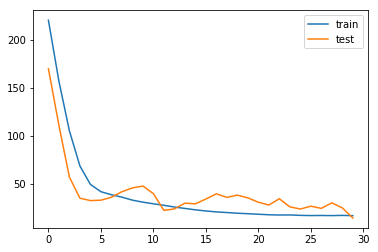

dict_keys(['loss', 'val_loss'])


In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

print(history.history.keys())


## Evaluate the model


In [23]:
# make a prediction
yhat = model.predict(test_X)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)
mae = np.sqrt(mean_absolute_error(y_test, yhat))
print('Test MAE: %.3f' % mae)


Test RMSE: 14.855
Test MAE: 3.792


## Comparing results

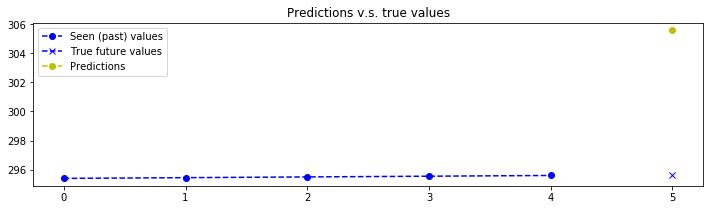

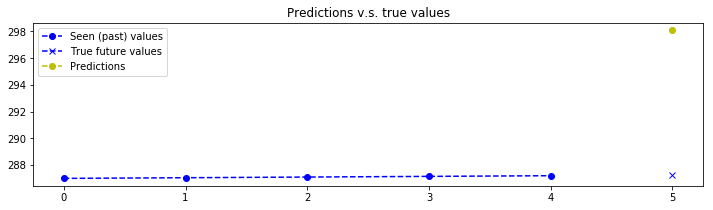

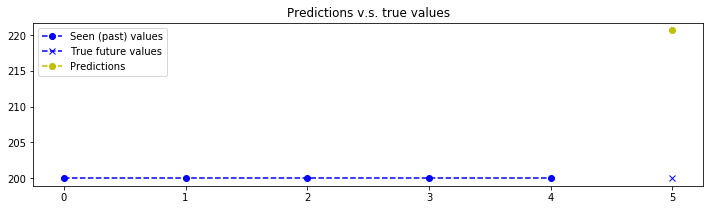

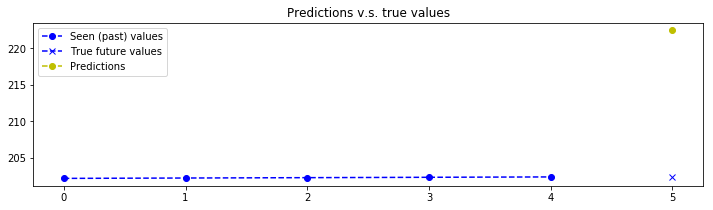

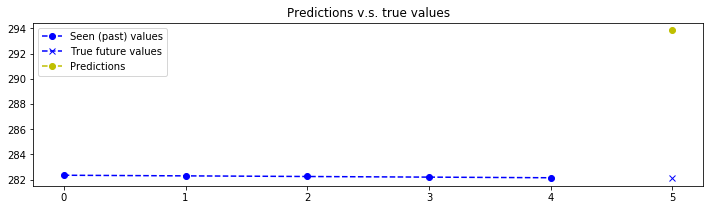

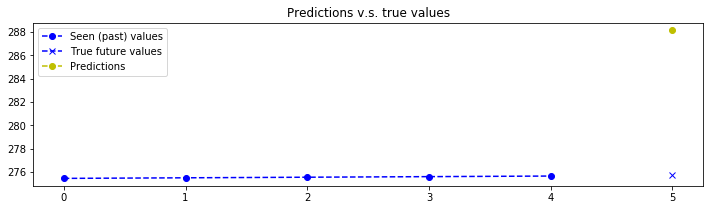

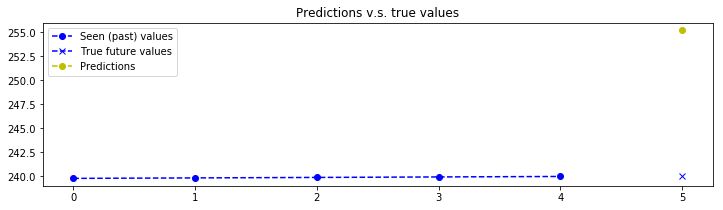

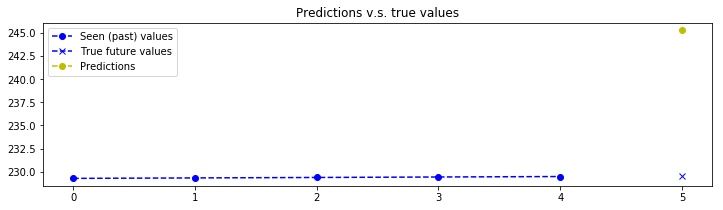

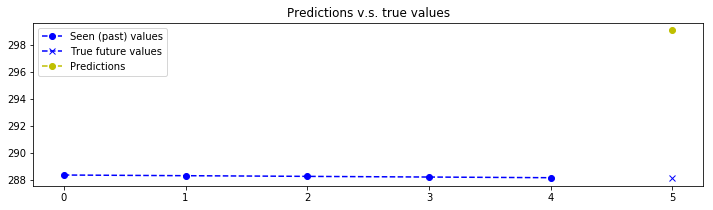

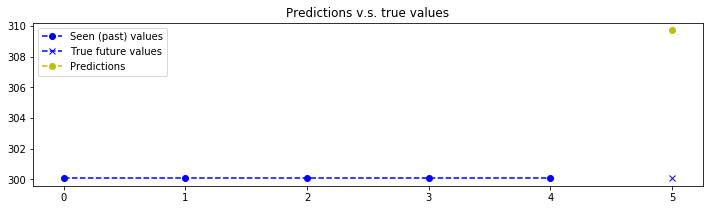

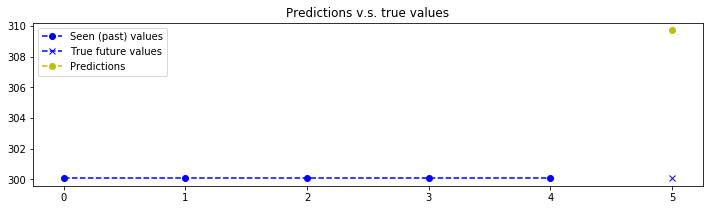

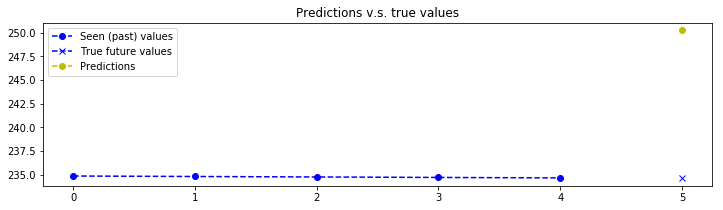

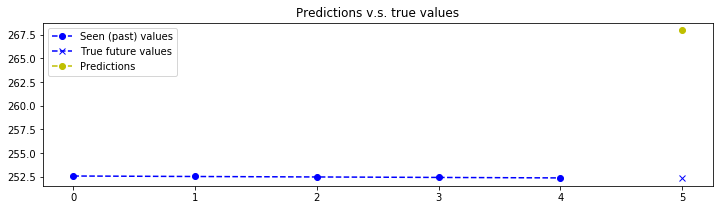

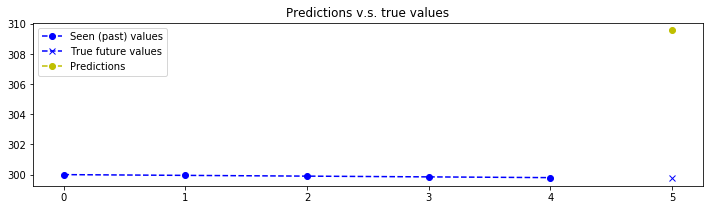

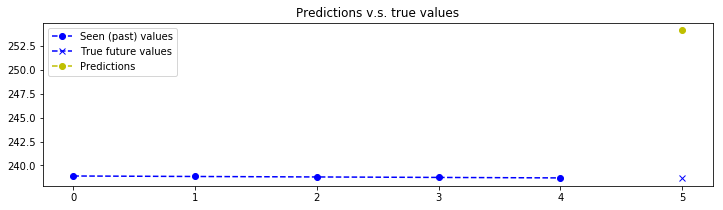

In [24]:
# Picked k random test instances
t_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

indices = np.random.choice(range(t_X.shape[0]), replace=False, size=15)
for index in indices:
    x_test = test_X[index]
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    plot_prediction(test_X_rescaled[0], [y_test[index]], yhat[index])

